# Quantitative Stock Portfolio Analyzer

## Project Goal
The goal of this project is to analyze the risk and trend profiles of three major tech stocks: **Apple (AAPL)**, **Microsoft (MSFT)**, and **Tesla (TSLA)**.

Instead of doing all the math in Python, we push the heavy lifting to the database layer using **SQL**. This simulates a real-world environment where data is too large to load entirely into memory.

## Key Concepts
1. **Volatility (Risk):** We calculate the standard deviation of daily returns. A higher number means the stock is "bouncier" or riskier.
2. **Moving Averages (Trends):** We smooth out daily noise to see the true direction of the stock price using a 30-day window.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

# We need to import our custom modules from the 'src' folder.
# '..' means "go up one level" to the project root.
sys.path.append(os.path.abspath('..'))

from src.storage import execute_sql_file

# Make the charts look clean and professional
plt.style.use('ggplot')

print("✅ Setup Complete. Libraries loaded.")

✅ Setup Complete. Libraries loaded.


## Part 1: Risk Analysis (Volatility)

**The Question:** Which stock is the riskiest to hold?

**The Math:**
To answer this, we look at **Volatility**. In finance, volatility is usually measured by the **Standard Deviation** of daily returns (percentage changes).
* If a stock goes up 1% today and down 1% tomorrow, it is stable (Low Std Dev).
* If a stock goes up 10% today and down 15% tomorrow, it is volatile (High Std Dev).


We used SQL to handle the aggregation (Variance), and we will use Python here to do the final math (Square Root).

--- Executing SQL file: ../sql/01_volatility.sql ---
Calculated Risk Metrics:


,ticker,variance,days_observed,std_dev
0,TSLA,0.001609,500,0.040108
1,AAPL,0.000311,501,0.017642
2,MSFT,0.000196,501,0.013987


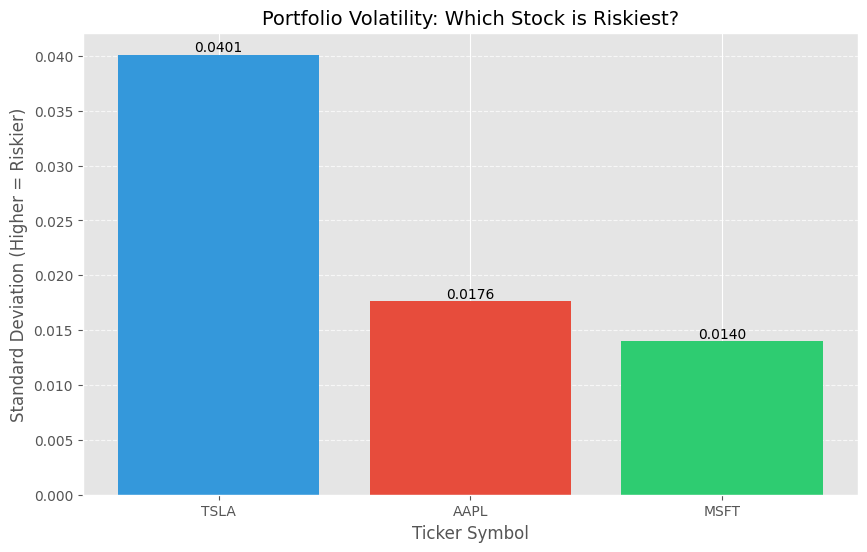

In [2]:
# 1. Execute the SQL logic
# This runs the query that calculates Variance manually
df_risk = execute_sql_file('../sql/01_volatility.sql')

# 2. Finish the Math
# Standard Deviation = Square Root of Variance
df_risk['std_dev'] = np.sqrt(df_risk['variance'])

# 3. Display the raw numbers
print("Calculated Risk Metrics:")
display(df_risk)

# 4. Visualize
# We use a simple Bar Chart to compare the three stocks side-by-side
plt.figure(figsize=(10, 6))
bars = plt.bar(df_risk['ticker'], df_risk['std_dev'], color=['#3498db', '#e74c3c', '#2ecc71'])

plt.title('Portfolio Volatility: Which Stock is Riskiest?', fontsize=14)
plt.xlabel('Ticker Symbol')
plt.ylabel('Standard Deviation (Higher = Riskier)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add the actual numbers on top of the bars for clarity
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, 
             f'{height:.4f}', 
             ha='center', va='bottom')

plt.show()

**Observation:**
As expected, **Tesla (TSLA)** shows the highest standard deviation. This confirms it is the most volatile asset in this portfolio. An investor would expect higher potential returns from Tesla to compensate for this higher risk. Microsoft and Apple are generally more stable.

## Part 2: Trend Analysis (30-Day Moving Average)

**The Question:** Is the stock price actually going up, or is it just noise?

**The Math:**
Stock prices are jagged. They spike up and down every day. To see the real trend, we use a **Simple Moving Average (SMA)**.
* We take the price of today and the previous 29 days.
* We average them together.
* This creates a smooth line that filters out temporary shocks.

**The SQL Strategy:**
We used a **Window Function** in SQL:
`AVG(close) OVER (PARTITION BY ticker ORDER BY date ROWS BETWEEN 29 PRECEDING AND CURRENT ROW)`

This allows us to calculate the rolling average for *every single day* without collapsing the data.

--- Executing SQL file: ../sql/02_moving_avg.sql ---


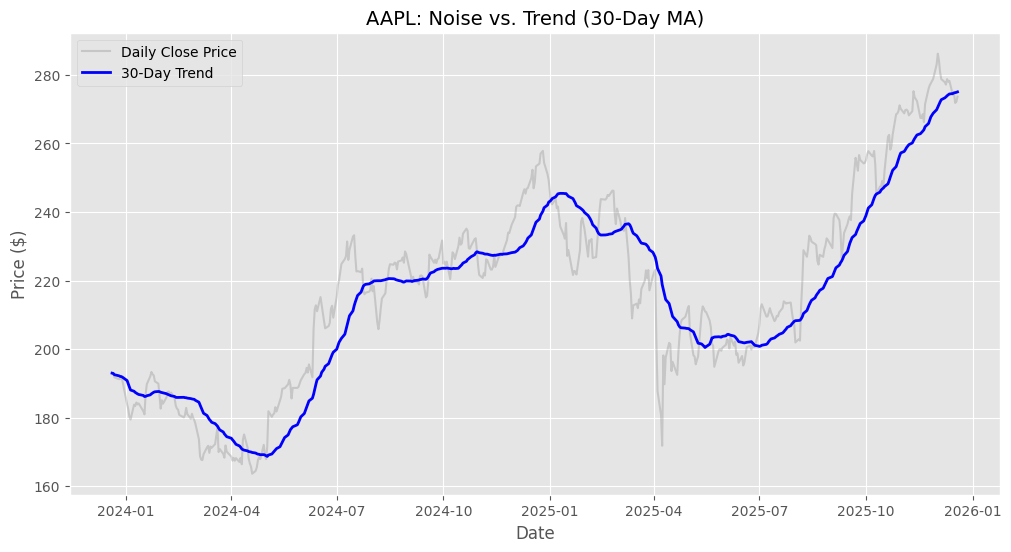

In [3]:
# 1. Execute the SQL logic
df_ma = execute_sql_file('../sql/02_moving_avg.sql')

# 2. Prepare Data for Plotting
# We will focus on Apple (AAPL) to keep the chart readable
target_stock = 'AAPL'
df_plot = df_ma[df_ma['ticker'] == target_stock].copy()

# Convert the text date to a real Date Object so Python treats it like time
df_plot['date'] = pd.to_datetime(df_plot['date'])

# 3. Visualize
plt.figure(figsize=(12, 6))

# Plot the raw daily price (The "Noise")
plt.plot(df_plot['date'], df_plot['close'], label='Daily Close Price', color='gray', alpha=0.3)

# Plot the 30-Day Moving Average (The "Signal")
plt.plot(df_plot['date'], df_plot['ma_30_day'], label='30-Day Trend', color='blue', linewidth=2)

plt.title(f'{target_stock}: Noise vs. Trend (30-Day MA)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)

plt.show()

## Conclusion

By using a modular ETL approach and SQL window functions, we successfully:
1. Identified **Tesla** as the highest volatility asset.
2. Smoothed out **Apple's** price action to identify long-term trends.

This workflow demonstrates how SQL can handle heavy statistical lifting before data even reaches the Python analysis layer, a critical pattern for working with large-scale financial datasets.